# Descriptive sentence generator walkthrough

In this notebook, we will walk the reader through how we developed the second part of our Taboo implementation project: the Taboo player. 
The ultimate goal of the player is to receive as input one Taboo-style card, containing a main word and its taboo words (generated by the card generator in the first part of this project), and to output a sentence describing the main word without using the taboo words.

Here, we present the steps we took to approach this challenge. 

Simply put, our strategy is the following:

* Train the GRU-based neural network with trigrams from our bespoke corpus of descriptive sentences. The use of trigrams was inspired by several implementations we found online attempting to complete a similar text generation task, as well as the PyTorch tutorial in class. The relevant papers and blog posts are referenced in the project reports and below.
* Use the main word as grounding point or seed for the final sentence. Using multiple seeds should allow us to generate sentences related to the main word, without deviating too much as the distance from the seed increases. Our whole sentence will be the concatenation of as many smaller generated sequences as we have seeds.
* Start an iterative process in which each segment of the sentence keeps being generated until we detect some words in it that are either the taboo words or words that are semantically related to the main word, indicating that that chunk might be semantically related to the main word.
* Clean the final sentence to remove the main word and any taboo words.

We trained 3 models to test our strategy. They are all GPU-based RNN models, trained on a CPU with 100 epochs.
* 1:
    * Model with 1 hidden layer consisting of 150 nodes. Trained with a sample of 50,000 non-filtered trigrams containing ~16k tokens from our corpus' vocabulary (which has a total of ~80k tokens, from which more than half only appeared once). Set of trigrams properly stored. Trained in about 12 hours.
* 2:  
    * Model with 2 hidden layers consisting of 75 nodes each. Also trained with a sample of 50,000 non-filtered trigrams containing ~16k tokens from our corpus' vocabulary. Unfortunately, we forgot to include a random seed for the sampling process and we did not save the corresponding set of trigrams. Although the generation step might work, it is not advised to use this model. Trained in about 5 hours.
* 3:
    * Model with 3 hidden layers consisting of 50 nodes each. Trained with a sample of ~86k filtered trigrams containing ~19k tokens from our corpus' vocabulary. ("Filtered" means that the model was only trained on trigrams containing tokens that appear at least twice in our corpus.) Although a random seed (163) was now included, for efficiency reasons we also decided to save the trigrams in order to load them faster and make reproducibility easier. Trained in about 11 hours.

## Section 0: Importing all necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import random
import string
import os
import torch
import pickle
import torch.nn as nn
from torch.autograd import Variable 
import math
import time
import gs_probdist as gspd
import semrel as sr
import gensim
import cardgen as cg 

### Setting up the gensim model used for card generation and semantic relations mining


In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

## Section 1: Creating and loading our bespoke corpus

Since we wanted to use this project to gain experience implementing neural network learning methods, and more specifically as a first approach to text generation, it was essential to get our hands on a suitable corpus that would result in meaningful inference after using it for training. 

For this purpose, we built a corpus based on the web corpus [ENCOW16A](https://corporafromtheweb.org/encow16/) consisting of ~115k sentences with the desired descriptive structures. For more detail on how the corpus was created, see `text-generation/description-corpus/create_corpus_from_csvs.ipynb`.

(The smaller version of the corpus (~20k sentences) was used for prototyping and development, but any final training and text generation was implemented with the complete version.)

In [2]:
#opening and reading the corpus
f = open('description-corpus-115k.txt', 'r', encoding='utf-8')
text = f.readlines()
f.close()

# getting lower case and splitting each sentence
sentences = [text[i].lower().split() for i in range(len(text))]

#getting the average length of a descriptive sentence
lengths = [len(sent) for sent in sentences]
avg_sent_length = sum(lengths)/len(lengths) # ~27

We will aim to generate sentences of the same length as the average sentence length in our corpus, namely 27 words or symbols.

## Section 1b: Cleaning the corpus

Before dividing our sentences into trigrams, we experimented with the basic cleaning and normalizing techniques
* removing stop words,
* removing punctuation symbols, and
* lemmatizing.

Below, we present the code for each one of these steps. 
We ultimately decided against implementing any of them in the final version of our code, since, for the strategy we have in mind, the goal of the GRU-based text generator is to produce grammatically correct sentences, for which we need stop words and punctuation.

In [4]:
# getting rid of stop words
#stop_words = set(nltk.corpus.stopwords.words('english'))
#stop_free = ' '.join([word for word in text.split() if word not in stop_words])

# getting rid of punctuation
#punctuation_symbols = set(string.punctuation)
#punct_free = "".join(word for word in stop_free if word not in punctuation_symbols)

# lemmatizing
#lemma = nltk.stem.wordnet.WordNetLemmatizer()
#normalized = ' '.join(lemma.lemmatize(word) for word in punct_free.split())

### Modifying the corpus to account for Zipf's law
Simply put, Zipf's law is an empirical law according to which the frequency use of different words follows a 
distribution that can be approximated by $$P_n \propto \frac{1}{n^a} $$ where $P_n$ represents the frequency of the n-th most frequent word and $a$ is a positive exponent usually slightly higher than 1. This means that the second most frequent word will be found roughly half as often as the most frequent one, the third most frequent word roughly one third as often as the most frequent one, and so on.

While examining our corpus, we also found some weirdly tokenized words.
For example, "binoculars" was imported as "bi no cu lars". 

Below we show a small analysis that we did on our corpus trying to understand the effect of these tokenizing mistakes. For practical purposes the goal is to get rid of those meaningless extra tokens so they are not considered during the generation process.

That is why, from the third model on, we decided to work with a version of the corpus in which any token appearing only once, i.e. a hapax legomenon, was removed.
The initial idea was to replace all of these by the "UNKNOWN" token. 
However, since searching and replacing items in such a big string was very inefficient (and "UNKNOWN" would have been a poor choice of flag token), we ended up adding the filtering into the trigram creation step.

In [3]:
# reading in the corpus as one big text this time
f = open('description-corpus-115k.txt', 'r', encoding='utf-8')
whole_text = f.read()
f.close()

Applying now nltk's `FreqDist()` function to create a dictionary with token:frequency pairs.

In [6]:
token_freq = nltk.FreqDist(whole_text.lower().split())
len(token_freq)

88331

Before applying the cleaning step, our total vocabulary consists of ~88,000 tokens.

Now that we have this dictionary we can get an idea of the frequency distribution of its values. 

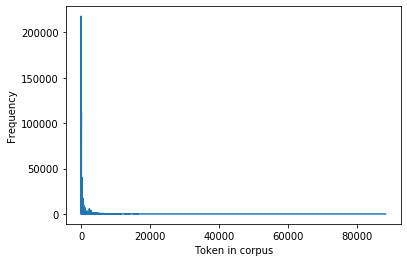

In [78]:
freq_dist_dict = dict(token_freq)
freqs = np.array([v for i, (k, v) in enumerate(freq_dist_dict.items())])

plt.plot(freqs)
plt.xlabel('Token in corpus')
plt.ylabel('Frequency')
plt.show;

Given the plot above and after computing some percentiles for the frequency of values, we concluded that in the context of our project it is justified to get rid of all tokens appearing only once throughout the corpus. This should result in better context-target relations in the network and increase the chances of getting meaningful sentences from the generator.

In [7]:
# deleting all the tokens that appear only once (i.e. hapax legomena)
to_delete = [k for k,v in token_freq.items() if float(v) == 1]
for k in to_delete:
    del token_freq[k]
len(token_freq)

41453

By applying this filter we got rid of roughly half of our tokens. 
We will use this list of hapax legomena to create trigrams that don't contain any of the hapaxes in the next step.
These trigrams will be used starting with the third model.

## Section 2: Implementing trigrams and setting up variables that will go into the network

Here we create the trigrams, consisting of two preceding context tokens and the target token, that will be fed into the neural network.

In [4]:
#in case we are loading a particular set of trigrams, run this cell
#if we do this we can then skip to the cell defining the vocabulary. It starts with voc = set()
with open("trigrams_test6.txt", "rb") as fp:
    trigrams = pickle.load(fp)
    

In [3]:
temp_trigrams = []
#getting trigrams sentence by sentence
for sentence in sentences:
    temp_trigrams += [([sentence[i], sentence[i+1]], sentence[i+2]) for i in range(len(sentence) - 2)]
len(temp_trigrams)

2921828

Each trigram will have this structure:

In [4]:
temp_trigrams[0]

(['it', 'does'], 'not')

Any training sessions we tried to implement using all trigrams without filtering resulted in kernel death. Our guess is that including all ~3,000,000 was too much. That is why for the first and second models we decided to draw 50,000 samples.

In [ ]:
random.seed(163)
temp_trigrams = random.sample(temp_trigrams, 50000)

As a consequence, our vocabulary length for the first and second models dropped from 88,331 tokens to about ~16,500. But we have to keep in mind that more than half of those ~88,000 tokens only appeared once in the corpus.

On a first approach we added the filtering step into the trigram generation step, but filtering $\sim$3,000,000 objects was also very inefficient. That is why we decided to first do the sampling and then remove all trigrams that include any hapax legomena in to_delete.

In [ ]:
trigrams = []
#we will only accept those consisting only of tokens that appear at least twice
for tri in temp_trigrams:
    if tri[1] not in to_delete:
        if tri[0][0] not in to_delete:
            if tri[0][1] not in to_delete:
                trigrams.append(tri)

Even with this solution, generating the trigrams takes a while, so we will use `pickle` to save the object as a `.txt` file. This will allow us to reproduce results faster.

In [ ]:
#saving the current set of trigrams
with open("trigrams_test6.txt", "wb") as fp:
    pickle.dump(trigrams, fp)

In the next cell we create a set containing all tokens found in our trigrams. From now on this will be our vocabulary, and its length will be the size of our network's input and output layers. We will also create a dictionary with token:frequency pairs that will allow us to assign numerical values to each trigram and therefore to have a way to make computations with them. 

In [5]:
voc = set()
for tri in trigrams:
    voc = voc.union(set(np.union1d(np.array(tri[0]), np.asarray(tri[1]))))
    
voc_length = len(voc)

word_to_freq = {word: i for i, word in enumerate(voc)}

The last preparation step is creating tensors containing the frequencies of each element and of each trigram. These tensors are the arguments we pass onto the training function and contain the context-target relationships from which our model will learn. 

In [6]:
#creating lists where we will store the input tensors
cont = []
tar = []
for context, target in trigrams:
    #creates a tensor with the frequency of both current context words
    context_freqs = torch.tensor([word_to_freq[word] for word in context], dtype = torch.long)
    #adds the tensor to cont
    cont.append(context_freqs)
    # does the same for the target and its frequency
    target_freq = torch.tensor([word_to_freq[target]], dtype = torch.long)
    tar.append(target_freq)

### Exploring the relation between number of trigrams and length of our vocabulary

From the first two models, it was clear that, while including more trigrams leads to better text generation, it also meant having a larger vocabulary size, which in turn directly affects the number of nodes in our network's input and output layers.
We were curious about the relationship between these two variables of trigrams and vocabulary size, so we plotted their relationship and used that plot to decide on an acceptable value for the number of trigrams used.

Note that running the chunk below will modify the trigram and vocabulary sets from the previous parts. 
If that happens, please re-run the code from the trigrams implementation section above before moving on.

In [8]:
random.seed(163)

temp_trigrams = []
#getting all trigrams in the corpus
for sentence in sentences:
    temp_trigrams += [([sentence[i], sentence[i+1]], sentence[i+2]) for i in range(len(sentence) - 2)] #if (sentence[i] not in to_delete and sentence[i+1] not in to_delete) and sentence[i+2] not in to_delete]

size_trigrams = np.arange(10000, 100000, 10000)
size_vocab = np.zeros(len(size_trigrams))

#for each sample size, cleaning the set of trigrams and getting its vocab size.
for i in range(len(size_trigrams)):
    sampled_trigrams_temp = random.sample(temp_trigrams, size_trigrams[i])
    trigrams = []
    for tri in sampled_trigrams_temp:
        if tri[1] not in to_delete:
            if tri[0][0] not in to_delete:
                if tri[0][1] not in to_delete:
                    trigrams.append(tri)
    voc = set()
    for tri in trigrams:
        voc = voc.union(set(np.union1d(np.array(tri[0]), np.asarray(tri[1]))))
    size_vocab[i] = len(voc)

<function matplotlib.pyplot.show(*args, **kw)>

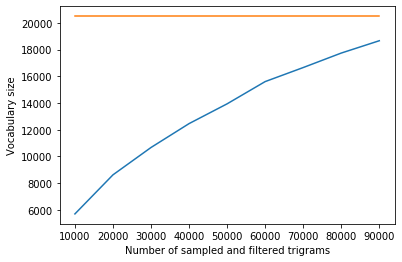

In [10]:
plt.plot(size_trigrams, size_vocab, size_trigrams, np.repeat(20500, len(size_trigrams)))
plt.xlabel('Number of sampled and filtered trigrams')
plt.ylabel('Vocabulary size')
plt.savefig('trigrams_vs_vocab.png')
plt.show

* The orange line has a value of 20,500 and represents half of the vocabulary size.
* The blue line represents the number of trigrams we sampled versus the vocabulary size they contain.

Because it seems that the marginal training cost (reflected by the vocabulary size) of including more trigrams is decreasing (we see this tendency in the slope), we decided to include ~90,000 trigrams in our third model. From the plot above we see that with this number of trigrams we are capturing relations representing about half of the total vocabulary size. Since we sampled randomly from the set of all trigrams, we also have a random sample of our vocabulary. And because of Zipf's law we can be certain that with a sample of about half the vocabulary size we are capturing most of the meaningful tokens.

## Section 3: Building the network and training it

As mentioned above, this section was inspired by the PyTorch tutorial we had during the class period and by several papers and blog posts. They are all referenced in the project reports and at the end of both the demo and the walkthrough.

As always, the first step is to check if we have a GPU to train our model on. 
It was not the case for any of our trials, but we will include the code for future reference and implementations. 
Note that since we knew that we would not have access to GPUs, our code does not include several .cuda() sections that would be necessary to run it in a GPU setup. 

In [7]:
#Cheking if we have a GPU to train our model on
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Fancy setup!')
else: 
    print('Too bad, training on CPU. Keep the number of epochs low!')

my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Too bad, training on CPU. Keep the number of epochs low!


Then we defined our `torch.nn` class and its usual methods. We decided to implement a GRU-based network, rather than an LSTM. This choice is justified in the project report.

Because of both time and computational power limitations, many of the features we decided to implement were the common choice among our sources: the decoder linear type, `Variable` as the autograd method, the step optimizer using `Adam`, and cross entropy loss as the loss criterion. 

The network parameters we did experiment with were the sizes of the input, output and hidden layers and also the number of hidden layers. Although the rule of thumb is generally to start with a number of nodes in the hidden layers that is on the same order of magnitude as the input or output layers, we estimated that doing so was going to result in training times longer than reasonable for the scope of the project.

The main objective of this text generator was to output coherent and grammatically correct sentences. Of course, generating sequences of tokens related to a certain seed (so that the text generator is actually describing the main word) is also an important objective, but we attempted to brute-force this into the final output rather than incorporate it at this stage.

In [8]:
class GRU(nn.Module):
    #init for input size, hidden size, output size and number of hidden layers.
    def __init__(self, input_s, hidden_s, output_s,n_layers = 1):
        super(GRU, self).__init__()
        self.input_s = input_s #length of our vocab
        self.hidden_s = hidden_s #to experiment with
        self.output_s = output_s #length of our vocab
        self.n_layers = n_layers #to experiment with
        # our encoder will be nn.Embedding
        # reminder: the encoder takes the input and outputs a feature tensor holding the information representing the input.
        self.encoder = nn.Embedding(input_s, hidden_s)
        #defining the GRU cell, still have to determine which parameters work best
        self.gru = nn.GRU(2*hidden_s, hidden_s, n_layers, batch_first=True, bidirectional=False)
        # defining linear decoder
        self.decoder = nn.Linear(hidden_s, output_s)
    
    def forward(self, input, hidden):
        #making sure that the input is a row vector
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1,-1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_s))
    
def train(context, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for t in range(len(trigrams)):
        output, hidden = decoder(context[t], hidden)
        loss += criterion(output, target[t])
        
    loss.backward()
    decoder_optimizer.step()
    
    return loss.data.item() / len(trigrams)

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

Next comes the training step. This set up corresponds to the third model we trained.

In [ ]:
#RUN THIS CELL ONLY IF YOU WANT TO TRAIN A NEW MODEL. THE MODELS WE ALREADY TRAINED CAN BE LOADED IN THE NEXT CELL
n_epochs = 100
print_every = 5
plot_every = 10
hidden_s = 50
n_layers = 3
lr = 0.015

decoder = GRU(voc_length, hidden_s, voc_length, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
for epoch in range(1, n_epochs + 1):
    loss = train(cont,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

In [ ]:
#saving the current model's state_dict
path = os.getcwd()+'/test6_trained_inference.pt'

torch.save(decoder.state_dict(),path)

In [9]:
#Loading an already trained decoder
path = os.getcwd()+'/test6_trained_inference.pt'
#make sure that the following structure coincides with the one of the model being loaded
hidden_s = 50
n_layers = 3
lr = 0.015
decoder = GRU(voc_length, hidden_s, voc_length, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
decoder.load_state_dict(torch.load(path))
decoder.eval()

GRU(
  (encoder): Embedding(18665, 50)
  (gru): GRU(100, 50, num_layers=3, batch_first=True)
  (decoder): Linear(in_features=50, out_features=18665, bias=True)
)

## Section 4: Generating our taboo player's descriptive sentence

Now that we trained our decoder, we are able to generate sentences iteratively token by token. In order to do this, we will generate a distribution of possible next tokens based on a seed and choose the most likely one.

In [10]:
def next_token_generator(seed, generation_length=100):
    """
    Given a seed and a length, it returns a sequence of generated tokens. 
    It generates the tokens one by one, concatenating the new tokens to the seed and taking the seed's last two tokens as context for the next generation.

    Arg:
        seed: a string of minimal length = 2 which will serve as context for the first generation step.
        generation_length: integer value representing the number of tokens we desire to generate.
    Returns:
        A string consisting of the concatenation of the seed and all generated tokens.
    """
    
    hidden = decoder.init_hidden()

    for p in range(generation_length):
        
        prime_input = torch.tensor([word_to_freq[w] for w in seed.split()], dtype=torch.long)
        cont = prime_input[-2:] #last two words as input
        output, hidden = decoder(cont, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).exp()
        top_choice = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_freq.keys())[list(word_to_freq.values()).index(top_choice)]
        seed += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return seed

With a working sentence generator that in theory is able to produce coherent sequences, the next challenge was to use it in a way that would return a sequence with enough meaningful words related to our main word. 

First, we generated a set of input words that are related in some way to our main word. This set includes the main word's hypernyms, hyponyms, and synonyms (using the semantic relations encoded in WordNet and functions implemented for the card generator), as well as all taboo words. We are aiming to have a certain number of these words in our final sentence.

Below is the code to generate these `input_words` sets.

In [11]:
def gen_input_words(mw, model):
    """
    Given a main word and a gensim model, it generates a set of input words that we are aiming to have in our descriptive sentence.
    Arg:
        mw: a string containing the main word that we are aiming to describe
        model: gensim model from which we are retrieving words semanticaly related to the mw 
    Returns:
        A set of strings consisting of the mw, its synonyms, hypernyms and hyponyms, and all its associated taboo words. All of them contained in the vocabulary.
    """
    #generating the corresponding taboo card
    card_words = cg.card_generator(mw, cg.get_gold_probdist(), model)
    #set of words that we hope will appear in the description
    input_words = card_words[mw] + [mw]

    # extending the input_words set using semantic relations. Bigger set --> better chances of generating an approved word!
    # we will use the make_semrel_dict function to get synonyms, hyponyms and hypernyms of the MW.
    # we considered adding also semrel words from the tw, but they loose connection to the MW very fast
    # we will leave out antonyms as they might make they are "riskier" to use in a description.

    adds = []
    temp = sr.make_semrel_dict(mw)
    for k in temp.keys():
        if k != 'semrel_antonym':
            new = list(temp[k])
            adds += new
    adds = np.unique(adds)
    adds = [x.lower() for x in adds]
    input_words = np.unique(input_words + adds)

    # filtering out the input words that are not in our vocab.
    input_words = [word for word in input_words if word in voc]    
    return input_words

The next step is the iterative process by which we expect to have a descriptive sequence as an output. Our approach was to not limit ourselves to using only one seed, but to try using several. Even though it was clear from the beginning that simply concatenating generated `sub_segments` would not result in a coherent sentence, having many `sub-segment`s with their own seeds trying to generate related words in parallel increases our chances of finding `input_words` inside the final sequence.

The most frequent descriptive structures in our description corpus are "X is", "X means", and "X can be found". 
It is worth noting that the "is" seed appeared ~1000 times more often than "means", and "means" about ~100 times more often than "can be found". 
Our seed will always consist of our main word + "is" or "means" or "can be found". 
We limited the experiment to either 2 or 3 seeds in each sentence.

After each iteration, we assign a success score to the concatenated final sequence. The score is an integer counting how many of the input words we have in the sequence, without taking into account the initial seeds. We agreed that a score of 2 was high enough to be considered a success, meaning that two of the `input_words` should appear in the sentence as an indicator that the text being generated is semantically related to the main word. 

In case one of the segments generates a `sub_sequence` containing one of the `input_words`, we "block" that segment. 
This means that that segment will be locked down and the iteration will stop, so that it will stay constant throughout the rest of the process. All other `sub_segment`s will keep generating until the desired score is reached. 

(If `sub_segment` X includes an input word and has been "blocked", the next `sub_segment` X+1 takes X into account as part of its seed. Theoretically, this should help by adding better context into the generating step. However, while this is a good idea, this is actually not a useful strategy because `next_token_generator()` actually only takes the last two segments of each seed into account. Nevertheless, this idea is still part of the implementation below.)

For practical purposes we stop generating after some fixed number of iterations, should the score not be reached.

The code below describes this iterative process for the cases in which we use two or three seeds. We recommend reading first the part of the code describing the process for only two seeds, as the version for three seeds works exactly the same but is messier because of we had to cover more cases.

In [2]:
def description_generator(mw, model, n_seeds = 3, n_iterations = 10, debugging = False, printing = False):
    """
    Given the main word we are trying to describe, it will iteratively create sequences aiming to contain some of the input words generated by gen_input_words(mw, model).
    If the desired score was not reached it will return the last generated sequence, after doing n_iterations of the process.
    Arg:
        mw = main word as string
        model = embeddings used to generate the cards
        n_seeds = int, if we are using 2 or 3 seeds during the sentence generation step
        n_iterations = int, how many sequences we will test
        debugging = Boolean, True if we want to print some statistics about the process. False if we only want the last 5 generated sentences.
        printing = Boolean, True will print something, based on debugging. If false, it will only return the final sentence
    Returns:
        A string containing the last generated sequence.
    """
    #generating the input_words we are aiming to include in our description
    input_words = gen_input_words(mw, model)    
    #on average a descriptive sentence had 27 words/symbols.
    # we will equally divide them between our seeds
    
    
    # iterate until nice sentence comes up
    # we will add safety measure to not break everything
    i = 0
    index_in_sentence = -1
    
    
    #if we are using 3 seeds
    #the 3 most frequent ones in our corpus were "x is", 'x means' and "x can be found"
    if n_seeds == 3:
        #create the first sentence, dividing the whole sequence into equally long sub_sequences
        sentence_parts = np.array([next_token_generator(mw+' means', 7), next_token_generator(mw+' is', 7), next_token_generator(mw+' can be found', 5)])
        sentence =  " ".join(sentence_parts)
        eval_sentence = sentence.split()   
    
        # to keep track of scores
        scores = np.zeros(n_iterations)
        #first score vector and score
        #and accounting for the 3 times the MW appears already in the seeds
        score_vector = np.array([eval_sentence.count(word) for word in input_words])
        score_vector[input_words.index(mw)] -= 3 
        score = np.sum(score_vector)  

        # the covered vector will take care that we don't replace a segment that already contains an input word.
        covered = np.array([0,0,0])
        changes = np.zeros(len(score_vector))

        #known positions of input words in our sentence to know where input words are located and to which sub_sequence they belong.
        positions = np.zeros(len(eval_sentence))

        #we know the positions of the seeds
        positions[0] = 1
        positions[9] = 1
        positions[18] = 1
        
        #for practical purposes we stop generating after some fixed number of iterations in case the score was not reached.
        while i < n_iterations and score <2 :
            #aware that with this flow we are doing one iteration after reaching the desired score, but it's no big deal because score is designed to only go up.

            #checking if score improved
            new_score_vector = np.array([eval_sentence.count(word) for word in input_words])
            new_score_vector[input_words.index(mw)] -= 3 
            changes = new_score_vector - score_vector

            if True in (changes>0): #there was a change in the score. Assuming there is max 1 change per iteration from now on
                index = np.where(changes == 1)[0][0] #looking for the position in which an input_word was added
                word_that_was_added = input_words[index]
                
                #finding in which segment that new added word is in order to leave the segment untouched

                #this detects the index of the word that just came up in case that word was already in our sentence
                indices_in_sentence = np.where(np.array(eval_sentence) == word_that_was_added)[0]
                if len(indices_in_sentence) >1: #word appears at least twice
                    for d in indices_in_sentence:
                        if positions[d] != 1:
                            index_in_sentence = d
                            positions[d] = 1
                else:
                    index_in_sentence = indices_in_sentence[0]
                    positions[index_in_sentence] = 1
                    
                #keeping the segment in which the improvement took place, blocking it and continue the generating process
                if index_in_sentence in range(9) & covered[0]!=1:
                    sentence_parts[1] = next_token_generator(mw+' is', 7)
                    sentence_parts[2] = next_token_generator(mw+' can be found', 5)
                    sentence = ' '.join(sentence_parts)
                    covered[0] = 1
                elif index_in_sentence in range(9, 18) & covered[1] !=1:
                    sentence_parts[0] = next_token_generator(mw+' means', 7)
                    sentence_parts[2] = next_token_generator(mw+' can be found', 5)
                    sentence = ' '.join(sentence_parts)
                    covered[1] = 1
                elif index_in_sentence in range(18, 27) & covered[2] != 1:
                    sentence_parts[1] = next_token_generator(mw+' is', 7)
                    sentence_parts[0] = next_token_generator(mw+' means', 7)
                    sentence = ' '.join(sentence_parts)
                    covered[2] = 1
                eval_sentence = sentence.split()
                changes = np.zeros(len(score_vector))
                index_in_sentence = 0
                score_vector = new_score_vector
                score = np.sum(score_vector)

            #if there was no change
            else: #based on what is already covered
                if covered[0] ==0:
                    sentence_parts[0] = next_token_generator(mw+' means', 7) +' '
                #if the first part is already covered we can add it as input to generate the second
                if covered[1] ==0:
                    if covered[0]==1:
                        temp =  next_token_generator(sentence_parts[0]+' '+ mw+' is', 7) 
                        #taking off the first part from it
                        temp = temp.split()
                        sentence_parts[1] = " ".join(temp[9:])   
                    else:
                        sentence_parts[1] = next_token_generator(mw+' is', 7) 
                # same logic for the third part.
                if covered[2] == 0:
                    if covered[1] == 0:
                        sentence_parts[2] = next_token_generator(mw+' can be found', 5)
                    else:
                        temp =  next_token_generator(sentence_parts[1]+' '+ mw+' can be found', 5) 
                        #taking off the second part from it
                        temp = temp.split()
                        sentence_parts[2] = " ".join(temp[9:])
                sentence = ' '.join(sentence_parts)
                eval_sentence = sentence.split()
                score_vector = new_score_vector
                score = np.sum(score_vector)
            
            #choosing what to print
            if i == 0:
                print('The set of input words we are trying to introduce into our sequence is: '+str(input_words))
            if printing == True:
                if debugging ==True:
                    print("Sentence number: " + str(i+1))
                    print(sentence)
                    if True in (changes>0):
                        print("Changes vector: ")
                        print(changes)
                    print("Covered vector: ")
                    print(covered)
                    print("Positions vector: ")
                    print(positions)
                    if i == n_iterations-1:
                            print('The final sentence got a score of: '+str(score))
                else:
                    if i in range(n_iterations-5, n_iterations):
                        print("Sentence number: " + str(i+1))
                        print(sentence)
                        if i == n_iterations-1:
                            print('The final sentence got a score of: '+str(score))
            scores[i] = score
            i +=1
            
    #if we are using 2 seeds
    #the 2 most frequent ones in our corpus were "x is" and 'x means'
    if n_seeds == 2:
        #create the first sentence
        sentence_parts = np.array([next_token_generator(mw+' means', 11), next_token_generator(mw+' is', 12)])
        sentence =  " ".join(sentence_parts)
        eval_sentence = sentence.split()   
    
        # to keep track of scores
        scores = np.zeros(n_iterations)
        #first score vector and score
        #and accounting for the 3 times the MW appears already in the seeds
        score_vector = np.array([eval_sentence.count(word) for word in input_words])
        score_vector[input_words.index(mw)] -= 2
        score = np.sum(score_vector)  

        # the covered vector will take care that we don't replace a segment that we already "like"
        covered = np.array([0,0])
        changes = np.zeros(len(score_vector))

        #known positions of input words in our sentence
        positions = np.zeros(len(eval_sentence))

        #we know the positions of the seeds
        positions[0] = 1
        positions[14] = 1
        
        while i < n_iterations and score <2:
            #aware that with this flow we are doing one iteration after reaching the desired score, but it's no big deal because score is designed to only go up.

            #checking if score improved
            new_score_vector = np.array([eval_sentence.count(word) for word in input_words])
            new_score_vector[input_words.index(mw)] -= 2
            changes = new_score_vector - score_vector

            if True in (changes>0): #there was a change. Assuming there is max 1 change per iteration from now on
                index = np.where(changes == 1)[0][0] #looking for the position in which an input_word was added
                word_that_was_added = input_words[index] #if we stop assuming that, here we have to keep track of location and magnitude of changes
                
                #finding in which segment that new added word is in order to leave the segment untouched

                #this detects the index of the word that just came up in case that word was already in our sentence
                indices_in_sentence = np.where(np.array(eval_sentence) == word_that_was_added)[0]
                if len(indices_in_sentence) >1: #word appears at least twice
                    for d in indices_in_sentence:
                        if positions[d] != 1:
                            index_in_sentence = d
                            positions[d] = 1
                else:
                    index_in_sentence = indices_in_sentence[0]
                    positions[index_in_sentence] = 1
                #keeping the segment in which the improvement took place
                if index_in_sentence in range(14):
                    sentence_parts[1] = next_token_generator(mw+' is', 12)
                    sentence = ' '.join(sentence_parts)
                    covered[0] = 1
                elif index_in_sentence in range(14, 27):
                    sentence_parts[0] = next_token_generator(mw+' means', 11)
                    sentence = ' '.join(sentence_parts)
                    covered[1] = 1
                eval_sentence = sentence.split()
                changes = np.zeros(len(score_vector))
                index_in_sentence = 0
                score_vector = new_score_vector
                score = np.sum(score_vector)

            #if there was no change
            else: #based on what is already covered
                if covered[0] ==0:
                    sentence_parts[0] = next_token_generator(mw+' means', 11) 
                #if the first part is already covered we can add it as input to generate the second
                if covered[1] ==0:
                    if covered[0]==1:
                        temp =  next_token_generator(sentence_parts[0]+' '+ mw+' is', 12)
                        #taking off the first part from it
                        temp = temp.split()
                        sentence_parts[1] = " ".join(temp[12:])   
                    else:
                        sentence_parts[1] = next_token_generator(mw+' is', 7)
                sentence = ' '.join(sentence_parts)
                eval_sentence = sentence.split()
                score_vector = new_score_vector
                score = np.sum(score_vector)
                
            #choosing what to print
            if i == 0:
                print('The set of input words we are trying to introduce into our sequence is: '+str(input_words))
            if printing == True:
                if debugging ==True:
                    print("Sentence number: " + str(i+1))
                    print(sentence)
                    if True in (changes>0):
                        print("Changes vector: ")
                        print(changes)
                    print("Covered vector: ")
                    print(covered)
                    print("Positions vector: ")
                    print(positions)
                    if i == n_iterations-1:
                            print('The final sentence got a score of: '+str(score))
                else:
                    if i in range(n_iterations-5, n_iterations):
                        print("Sentence number: " + str(i+1))
                        print(sentence)
                        if i == n_iterations-1:
                            print('The final sentence got a score of: '+str(score))
            scores[i] = score
            i +=1
    return sentence

If we would let the generator iterate until a score of two had been reached, we would have a final sequence of tokens containing two of the input words that would ideally be meaningful for guessing the main word. In order to present that final "sentence", we have to make sure that it does not include the main word nor the taboo words.

First, we replaced any instances of the main word by the string "The main word".

Then, for the taboo words: following what a human taboo player might do, we decided to look for synonyms (that are themselves not taboo words or the main word) and choose one randomly. If there are no synonyms, we will look for hypernyms and paraphrase the sentence to transmit that change, saying instead "is a type of [hypernym]". If there also aren't any hypernyms, the player panics and says "No idea!" for that position of sequence.

In [13]:
def sentence_cleaner(sentence, mw, model):
    '''
    Makes sure that the generated sequence given by description_generator() follows taboo rules and does not contain the main word or any taboo word.
    Arg: 
        sentence: string containing the sequence to clean
        mw: string containing the main word we are playing with 
        model: gensim embeddings model we are retrieving semantic relations from
    Returns:
        A string containing a version of the descriptive sentence that follows taboo rules.
    '''
    #replacing MW with "the main word" and TWs appearing in the sentence with one of their synonyms
    sentence = sentence.replace(mw, '.The main word')
    
    #replacing any TWs appearing in our sentence with some allowed synonym
    taboo_words = cg.card_generator(mw, cg.get_gold_probdist(), model)[mw]

    spl = np.array(sentence.split())
    for tw in taboo_words:
        if tw in spl:
           #getting synonyms of detected tw
            syns = sr.get_synonyms(tw)
            #if we have at least one
            if len(syns) > 0:
                syns = list(syns)
                #choose one randomly
                choice = np.random.choice(syns)
                #checking that the choosen one it not a taboo word either, or the main word + making sure that it doesn't loop
                while (choice in taboo_words or choice != mw) and len(syns) > 0:
                    syns = syns.pop(syns.index(choice))
                    choice = np.random.choice(syns)
                sentence = sentence.replace(tw, choice)
                #if all synonyms where taboo words or the mw
                if choice in taboo_words or choice == mw:
                    hypers = sr.get_hypernyms(tw)
                    #if we have at least one
                    if len(hypers) > 0:
                        hypers = list(hypers)
                        #choose one randomly
                        choice = np.random.choice(hypers)
                        #checking that the chosen one is not a taboo word either, or the main word + making sure that it doesn't loop indefinitely
                        while (choice in taboo_words or choice != mw) and len(hypers) > 1:
                            syns = syns.pop(syns.index(choice))
                            choice = np.random.choice(syns)
                        #replacing in order to point the reader to think of this word as a hypernym 
                        sentence = sentence.replace(tw, choice)
                        #if all synonyms where taboo words or the mw
                        if choice in taboo_words or choice == mw:
                            sentence = sentence.replace(choice, "ERROR, NO IDEA!")  #panicking as a real player would.
                        else:
                            sentence = sentence.replace(choice,'is a type of '+choice)
            #in case no synonyms were found
            else:
                hypers = sr.get_hypernyms(tw)
                #if we have at least one
                if len(hypers) > 0:
                    hypers = list(hypers)
                    #choose one randomly
                    choice = np.random.choice(hypers)
                    #checking that the chosen one is not a taboo word either, or the main word + making sure that it doesn't loop indefinitely 
                    while (choice in taboo_words or choice != mw) and len(hypers) > 1:
                        syns = syns.pop(syns.index(choice))
                        choice = np.random.choice(syns)
                        #replacing in order to point the reader to think of this word as a hypernym 
                        sentence = sentence.replace(tw, choice)
                        #if all synonyms where taboo words or the mw
                        if choice in taboo_words or choice == mw:
                            sentence = sentence.replace(choice, "ERROR, NO IDEA!")  #panicking as a real player would.
                        else:
                            sentence = sentence.replace(choice,'is a type of '+choice)
                else: 
                    sentence = sentence.replace(tw, "NO IDEA!")
    sentence = sentence[1:]
    return sentence

The final output function will implement all generating steps until either the desired score is reached (2 by default) or we iterate the given number of times (minimum 5). The printing and debugging arguments allow us to decide what we want to keep track of, as explained in `description generator()`.

In [19]:
def final_output(mw, model, n_seeds = 3, n_iterations = 10, debugging = False, printing = True):
    mw = mw.lower()
    sentence = description_generator(mw, model, n_seeds, n_iterations, debugging, printing)
    output = sentence_cleaner(sentence, mw, model)
    return output

In [20]:
final_output('airplane', model, n_seeds = 3, n_iterations = 10, debugging = True, printing = True)

The set of input words we are trying to introduce into our sequence is: ['airliner', 'airplane', 'biplane', 'fighter', 'flight', 'jet']
Sentence number: 1
airplane means ericsson printing orientation columbia workplace persev airplane is lighter opt dwarfs considerably leases contribution aquife airplane can be found fertilized warlord wise asleep economist
Covered vector: 
[0 0 0]
Positions vector: 
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 2
airplane means trying cost-effective res observed wristwatch don hoste airplane is thematic economist wellington pickle dwarfs dire keep airplane can be found carp right-wing seasonal pope guthrie
Covered vector: 
[0 0 0]
Positions vector: 
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 3
airplane means bar on-road believable bsa jihad condiment outwardly  airplane is soil workplace arranged tram classic enlargement goals airplane can 

'The main word means raping ponies jihad jihad classic normative chromecast  .The main word is homemade transmit bacterium invading inundated billboard e .The main word can be found processors burglary smashed elegantly stubbornly'

In [15]:
final_output(mw = 'Airplane', model = model, n_seeds=3, n_iterations = 6, debugging = True, printing = True)

The set of input words we are trying to introduce into our sequence is: ['airliner', 'airplane', 'biplane', 'fighter', 'flight', 'jet']
Sentence number: 1
airplane means surprising jihad causing jihad gun unfounded hoover  airplane is stitch bsa re classic deserving computation deny airplane can be found shout interestingly bsa attempt gun
Covered vector: 
[0 0 0]
Positions vector: 
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 2
airplane means meta -66 billboard motel persevered one-third rind  airplane is sleeps entertain dictatorships announced david layouts jihad airplane can be found programmed examined post-june juneau dog
Covered vector: 
[0 0 0]
Positions vector: 
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 3
airplane means quickest fourteen antithesis whig mame wherein bartender  airplane is professes forever outwardly face passover imac vid airplane can be found fea

'The main word means widespread excluding units saloon oranges swale anti-abor .The main word is ostomy restricts tyrannical greed cave bsa integrating .The main word can be found eris agreed illustrations dartford ucl'

## References
- Pytorch tutorials for the ANLP class WS19-20
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy
- [Beginners Guide to Text Generation (Pytorch)](https://www.kaggle.com/ab971631/beginners-guide-to-text-generation-pytorch) by Abhishek Kumar 
- [Text Generation with Pytorch](https://machinetalk.org/2019/02/08/text-generation-with-pytorch/) by Trung Tran. 

